In [237]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from matrix_factorization import matrix_factorization
from graph_init import *
from similarity import *
from create_R import *
from ALS import *
from hard_hfs import *
import copy
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
def RMSE(ground, predict):
    
    error = 0
    n = 0
    
    for i in range(len(ground)):
        for j in range(len(ground[0])):
            if ground[i,j] != 0:
                error += (ground[i,j] - predict[i,j])**2
                n += 1
                
    return np.sqrt(error/n)

def RMSEvec(ground, predict):
    
    error = 0
    n = 0
    
    for i in range(len(ground)):
        if ground[i] != 0:
            error += (ground[i] - predict[i])**2
            n += 1
                
    return np.sqrt(error/n)

def meanError(ground_truth,new_res):
    return np.mean(abs((new_res - ground_truth)[ground_truth!=0]))

def dictfromR(R):

    R_dict = {"Users": np.empty([0]), "Movies": np.empty([0]), "Ratings": np.empty([0])}

    for i in range(len(R)):
        for j in range(len(R[0])):
            if R[i,j] != 0:
                R_dict["Users"] = np.append(R_dict["Users"],i)
                R_dict["Movies"] = np.append(R_dict["Movies"],j)
                R_dict["Ratings"] = np.append(R_dict["Ratings"],R[i,j])

    return R_dict

In [239]:
R,R_dict = create_R()

print(R_dict)

/home/marc/Documents/MVA/ProjetGraphes/src/create_R.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  R[ratingsnp[i,0]-1, ratingsnp[i,-1]] = ratingsnp[i,2]


{'Movies': array([   30.,   833.,   859., ...,  4597.,  4610.,  4696.]), 'Users': array([   0.,    0.,    0., ...,  670.,  670.,  670.]), 'Ratings': array([ 2.5,  3. ,  3. , ...,  4. ,  2.5,  3.5])}


In [240]:
P_dict = copy.deepcopy(R_dict)
P_dict["Ratings"] = np.ones([len(R_dict["Ratings"])])
P = R > 0
print(P)

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [ True False False ..., False False False]
 [ True False False ..., False False False]]


In [241]:
to_keep = 99.99/100

iss, js = np.where(R > 0.1)
n_ratings = len(js)
ground_truth = copy.deepcopy(R)
shuf = np.array(range(n_ratings))
iss = iss[shuf]
js = js[shuf]

deleted_i = []
deleted_j = []
deleted = 0
i = 0
while deleted < len(iss)*(1-to_keep):
    if np.sum(R[iss[i]] > 0.1) > 1 and np.sum(R[:,js[i]] > 0.1) > 1:
        R[iss[i],js[i]] = 0
        deleted += 1
        deleted_i.append(iss[i])
        deleted_j.append(js[i])
    i += 1
        
    
# deleted_i = iss[:len(iss)*(1-to_keep)]
# deleted_j = js[:len(js)*(1-to_keep)]
# R[deleted_i, deleted_j] = 0

In [242]:
np.sum(R != 0)

99993

In [243]:
R_dictCopy = copy.deepcopy(R_dict)
R_dict = dictfromR(R)

In [244]:
print(RMSEvec(ground_truth[deleted_i,deleted_j],2.5*np.ones(len(deleted_i))))

0.674199862463


In [245]:
N = len(R)
M = len(R[0])
K = 4

als = ALS(K,N,M,"Users","Movies","Ratings",lbda = 0.1,lbda2 = 0.1)
print("Als created")
ans = als.fit(R_dict)

Als created


In [246]:
R_rec = np.dot(als.U,np.transpose(als.V))

In [247]:
print(RMSEvec(ground_truth[deleted_i,deleted_j],R_rec[deleted_i,deleted_j]))

0.91409271283


In [248]:
R_rec[deleted_i,deleted_j]

array([ 2.32561328,  2.53736249,  2.3614722 ,  2.10516956,  1.96307568,
        2.90948693,  2.33174968,  2.80083811,  2.40215483,  2.6283304 ,
        1.40441431])

In [249]:
lp = LaplacianParams()

# sim = similarity(als.U)
sim = build_graph(als.U, GraphParams())
# Seems to work better with U... 
L = build_laplacian(sim,lp)

In [250]:
lhfs = []
lconf = []
for i in range(len(R[0])):
    if i%1000 == 0:
        print(i)
    hfs0, confidence = simple_hfs(als.U, R[:,i]*2, L, sim)
    maxconfidences = np.array([max(confidence[i,:]) for i in range(len(confidence))])
    
    lim = np.percentile(maxconfidences, 90)
    
    lhfs.append(hfs0/2)
    lconf.append(maxconfidences > lim)

R_barre = np.vstack(lhfs).T
confs = np.vstack(lconf).T

0


/home/marc/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


1000
2000
3000
4000
5000
6000
7000
8000
9000


In [251]:
print(RMSEvec(ground_truth[deleted_i,deleted_j],R_barre[deleted_i,deleted_j]))

1.78376517003


In [252]:
R_barre_limited = R_barre * confs
R_barre_final = copy.deepcopy(R_barre_limited)
R_barre_final[R != 0] = 0
# R_dict_barre = dictfromR(R_barre_final)

In [253]:
N = len(R)
M = len(R[0])
K = 4

als_trans = ALS(K,N,M,"Users","Movies","Ratings",lbda = 0.1,lbda2 = 0.1)
print("Als created")
ans = als_trans.fitTransductive(R_dict,R_barre_final,C1=1,C2=.1)

R_rec_trans = np.dot(als_trans.U,np.transpose(als_trans.V))

Als created


In [254]:
print(RMSEvec(ground_truth[deleted_i,deleted_j],R_rec_trans[deleted_i,deleted_j]))

0.95859828853


In [262]:
enleves = np.array([10, 5, 5, 5, 1, 0.1, 0.01])
RMSEhfs = np.array([1.29175583478, 1.30757716728, 1.44788836719, 1.4249715405, 1.43950610356,1.26059863196, 1.78376517003])
RMSErand = np.array([1.48679317479, 1.43092295107, 1.43092295107, 1.43092295107, 1.58074389094, 1.2645196325, 0.674199862463])
RMSEals = np.array([2.78447829049, 4.42410671792, 3.11900504497, 3.36009286288, 2.97774025308,1.06654905746, 0.91409271283])
RMSEtrans = np.array([-1,-1, 1.32641438877, 1.43307918684, 1.62984802727, 1.07843682215, 0.95859828853])

<b>Transductive</b>

5% - 1 - 0.1 - 1.32641438877 

5% - 1 - 1   - 1.43307918684 

1% - 1 - 0.1   - 1.62984802727 

0.1% - 1 - 0.1   - 1.07843682215 

0.01% - 1 - 0.1   - 0.95859828853 

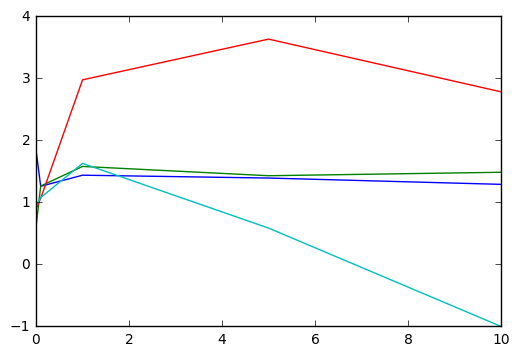

In [265]:
plt.plot(np.unique(enleves), [np.mean(RMSEhfs[np.where(enleves == i)]) for i in np.unique(enleves)])
plt.plot(np.unique(enleves), [np.mean(RMSErand[np.where(enleves == i)]) for i in np.unique(enleves)])
plt.plot(np.unique(enleves), [np.mean(RMSEals[np.where(enleves == i)]) for i in np.unique(enleves)])
plt.plot(np.unique(enleves), [np.mean(RMSEtrans[np.where(enleves == i)]) for i in np.unique(enleves)])

In [261]:
np.where(enleves == 0.01)

(array([], dtype=int64),)